# Intraday Liquidity Reporting

This notebook is a small preview to what we can do with [atoti](https://www.atoti.io/) for Intraday Liquidity monitoring based on [BCBS248](https://www.bis.org/publ/bcbs248.pdf):
- Daily maximum intraday liquidity usage
- Largest positive and negative net cumulative positions
- Gross payment sent and received

With that, we can easily derive the monthly reporting:  

<img src="img/monthly_report.png" width="1000px" />

Coupled with real-time capability, we can now monitor the cashflows. Check out how responsive the dashboard is, loading 500 records at 1s throttled speed:  

<img src="img/realtime_cashflow_monitoring.gif" width="1000px"/>  

_GIF is recorded at original speed without any processing!_

In [1]:
import random
import time

import pandas as pd

import atoti as tt

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=intraday_liquidity" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover.png" alt="Try atoti"></a></div>

## 1. Getting started

The general outline to [getting started with atoti](https://docs.atoti.io/latest/getting_started/tutorial/tutorial.html#Getting-started) is as follows:
1. Instantiate an [atoti session](https://docs.atoti.io/latest/lib/atoti/atoti.session.html#atoti.Session)
2. Create [atoti table(s)](https://docs.atoti.io/latest/lib/atoti/atoti.table.html)
3. [Join the atoti tables](https://docs.atoti.io/latest/getting_started/tutorial/tutorial.html#Enriching-the-cube) as necessary
4. [Create atoti cube](https://docs.atoti.io/latest/lib/atoti/atoti.session.html#atoti.Session.create_cube)
5. Proceed with [hierarchy manipulations](https://docs.atoti.io/latest/lib/atoti/atoti.hierarchies.html), [measure creation](https://docs.atoti.io/latest/lib/atoti/atoti.measure.html) and visualization.

Interwined with the business use case, we will show some tips on how to customize the solution.

### 1.1 Instantiate atoti session

We can easily instantiate [atoti session](https://docs.atoti.io/latest/lib/atoti/atoti.session.html#atoti.Session) without any parameters. However, in our use case, we have fixed the `port` for the web application and also persist our dashboards in the content folder as configured with the `user_content_storage` parameter.  

Here, we zoom in on the parameter `java_options` to see how we can customize the memory usage for the instance. The JVM default memory is set to use 25% of the machine memory.  
We used `-XX:MaxRAMPercentage` to dedicate 50% of the resources to the Java Heap. Check out the [_Deployment setup_](https://docs.atoti.io/latest/deployment/deployment_setup.html) guide in [atoti documentation](https://docs.atoti.io/) to find out more.

In [2]:
session = tt.Session(
    port=10011,
    user_content_storage="./content",
    java_options=["-XX:MaxRAMPercentage=50", "-XX:+UnlockExperimentalVMOptions"],
)

Access the web application from the link below. It's running on the port defined for the session above.  
Bear in mind that we have yet to create any cubes for the session. Hence, there's nothing we can do on the web application yet. We will come back to this later on.

In [3]:
session.link()

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

### 1.2 Create atoti tables  

There are two ways we can create atoti tables:
1. Use [`atoti.Session.create_table`](https://docs.atoti.io/latest/lib/atoti/atoti.session.html#atoti.Session.create_table) 
2. Use the `atoti.Session.read_*` functions where `*` depends on the type of data sources. E.g. we will use [`atoti.Session.read_csv`](https://docs.atoti.io/latest/lib/atoti/atoti.session.html#atoti.Session.read_csv) to read `CSV` files and [`atoti.Session.read_parquet`](https://docs.atoti.io/latest/lib/atoti/atoti.session.html#atoti.Session.read_parquet) to read parquet files.  

<strong>Differences between `create_table` and `read_*`</strong>

Using `create_table`, we will have to define the table structure all the way to the data type of the columns.  
In addition, the created table is empty. We will use the `atoti.Table.load_*` functions such as [`load_csv`](https://docs.atoti.io/latest/lib/atoti/atoti.table.html#atoti.Table.load_csv) to load data into the table.  

`read_*` functions creates the table based on the data source structure and loads the data.  
Data type is inferred for CSV types and inherited from Python objects such as Pandas DataFrame and the metadata of Parquet files.  

#### 1.2.1 Payment cashflows

We have created some mock cashflows for the month of September 2021 and some days in October 2021.  
Based on the direction of the cashflow, we know if it's payment sent or received:
- IN: Payment received
- OUT: Payment sent

For each day, we will receive the opening balance at the time 00:00:00 for each account, identified by the status _Open party_ or _Open posn_.

In [4]:
payment_tbl = session.read_parquet(
    "s3://data.atoti.io/notebooks/intraday-liquidity/cashflow_202110.parquet",
    table_name="Cashflows",
    keys=["Transaction_Id", "Transaction_Date", "Settlement_Date"],
)
payment_tbl.head()

,,,Legal_Entity,Country,Correspondent_Name,Correspondent_Account,Settlement_Currency,Settlement_Time,Status,Direction,Settlement_Amount,Net_Settlement_Amount,Opening_Balance,Available,Expected,Processing,Anticipated,Collateral,Outlook_Amount,Forecast_Amount
Transaction_Id,Transaction_Date,Settlement_Date,,,,,,,,,,,,,,,,,,
TXN2021090101391563A1,2021-09-01,2021-09-01,AU_BRANCH,UNITED STATES,"J.P Morgan Chase Bank, New York",987777175,USD,00:00:00,Open posn,IN,1.741638e+06,1.741638e+06,1.741638e+06,1.741638e+06,NaN,NaN,NaN,NaN,1.741638e+06,1.741638e+06
TXN2021090101391585A1,2021-09-01,2021-09-01,JP_BRANCH,JAPAN,Australia and New Zealand Banking Group Limite...,ATOTI-0030,JPY,00:00:00,Open posn,IN,2.816518e+08,2.816518e+08,2.816518e+08,2.816518e+08,NaN,NaN,NaN,NaN,2.816518e+08,2.816518e+08
TXN2021090101391588A1,2021-09-01,2021-09-01,HK_BRANCH,HONG KONG,Account 6,RAND-0024,HKD,00:00:00,Open party,IN,1.448327e+07,1.448327e+07,1.448327e+07,1.448327e+07,NaN,NaN,NaN,NaN,1.448327e+07,1.448327e+07
TXN2021090101391609A1,2021-09-01,2021-09-01,JP_BRANCH,JAPAN,Account 7,RAND-0025,JPY,00:00:00,Open posn,IN,2.347587e+08,2.347587e+08,2.347587e+08,2.347587e+08,NaN,NaN,NaN,NaN,2.347587e+08,2.347587e+08
TXN2021090101391613A1,2021-09-01,2021-09-01,US_BRANCH,UNITED STATES,Account 3,RAND-0039,USD,00:00:00,Open party,IN,1.914110e+06,1.914110e+06,1.914110e+06,1.914110e+06,NaN,NaN,NaN,NaN,1.914110e+06,1.914110e+06


#### 1.2.2 Time table for bucketing

The time table consists of the time buckets that allows us to look at the cashflows at hours, minutes or seconds intervals. It's basically a permutation of 24 hours x 60 minutes x 60 seconds.

In [5]:
time_tbl = session.read_csv(
    "s3://data.atoti.io/notebooks/intraday-liquidity/time.csv",
    keys=["Time"],
    types={
        "Time": tt.type.STRING,
        "Hour": tt.type.STRING,
        "Minute": tt.type.STRING,
        "Second": tt.type.STRING,
        "Minute (ext)": tt.type.STRING,
    },
    table_name="Time",
)

time_tbl.head()

,Hour,Minute,Second,Minute (ext)
Time,,,,
21:34:32,21,:34,:32,21:34
21:34:53,21,:34,:53,21:34
21:35:30,21,:35,:30,21:35
21:35:50,21,:35,:50,21:35
21:36:41,21,:36,:41,21:36


### 1.3 Join tables  

[Joining atoti table](https://docs.atoti.io/latest/getting_started/tutorial/tutorial.html#Join) is similar to how we perform table joins in databases. However, we apply [snowflake schema](https://en.wikipedia.org/wiki/Snowflake_schema) for atoti.  
This means that we choose a base table that is most granular and we centralize other fact tables around the based table.  

In this case, our base table is the payment table. So, we perform a join from `payment_tbl.Settlement_Time` to `time_tbl.Time` by specifying an explicit mapping.  

> Tips: Usually, we do not have to specify the mappings as atoti infers the relationship based on common column names between the tables.

In [6]:
payment_tbl.join(time_tbl, mapping={"Settlement_Time": "Time"})

Verify the table schema below:

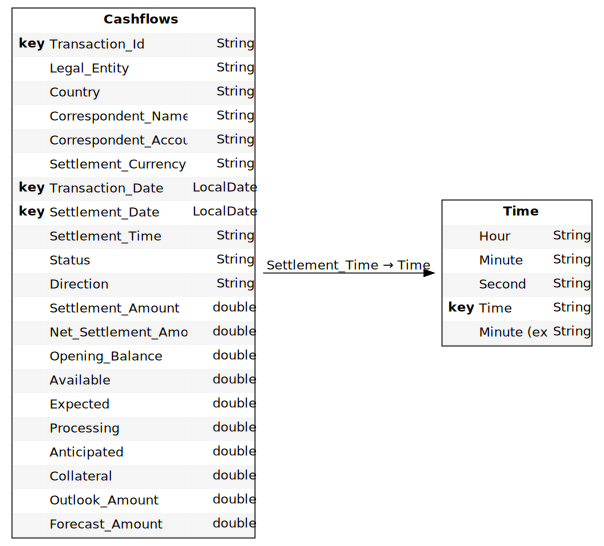

In [7]:
session.tables.schema

By joining the two tables via timestamps allows us to identify the time bucket each cashflow transaction falls under.

### 1.4 Create atoti cube

When we create a cube in `auto` mode, atoti creates a `mean` and a `sum` measure for each numerical columns. It's a great way to quickly explore the data and perform simple analytics.  
In this use case, to avoid cluttering of unwanted measures, we create the atoti cube with the `no_measures` mode.  
Check the [atoti documentation](https://docs.atoti.io/latest/lib/atoti/atoti.session.html#atoti.Session.create_cube) on the available modes.

In [8]:
cube = session.create_cube(payment_tbl, name="Intraday Liquidity", mode="no_measures")

> Tips: We could change the default limits set on some of the application behaviours such as `queriesTimeLimit`, `queriesResultLimit.intermediateLimit` and `queriesResultLimit.transientLimit`.  
  
  
Below we removed the restrictions on the intermediate results, which is a limit on the number of point locations for a single intermediate result.  
Check out the [shared contexts](https://docs.atoti.io/latest/lib/atoti/atoti.cube.html#atoti.Cube.shared_context).

In [9]:
cube.shared_context["queriesResultLimit.intermediateLimit"] = -1
cube.shared_context["queriesResultLimit.transientLimit"] = -1

## 2 Setting up atoti as monitoring tool  

In this section, we look at how we can manipulate the hierarchies and craft some measures to cater to our needs.  
Before we start, let's create alias variables for the cube attributes:

In [10]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

### 2.1 Creating basic measures

While cube in "auto" mode can create the basic `mean` and `sum` measures by default, we will create our measures manually to keep things lean and clean.  
Let's start with the easiest type of measure - summation. We will create it recursively for all the numerical columns in the payment table. Check out other available [aggregation functions](https://docs.atoti.io/latest/lib/atoti/atoti.agg.html).

In [11]:
def create_sum_measure(col_name, tbl):
    m[col_name] = tt.where(
        ~l["Settlement_Currency"].isnull(), tt.agg.sum(tbl[col_name])
    )

We have impose a [condition](https://docs.atoti.io/latest/lib/atoti/atoti.function.where.html#atoti.where) to return the summation only when `Settlement_Currency` is available in the query.  
This is important as we cannot add values such as `Settlement_Amount` across different currencies.

In [12]:
for col in payment_tbl.columns:
    if payment_tbl[col].data_type == "double":
        create_sum_measure(col, payment_tbl)

By creating the measures manually, we have control over the naming convention and the manner of implementation of the measures.  
Below are the measures created for columns of the type `double`.

In [13]:
m

{'contributors.COUNT': <atoti.measure.Measure object at 0x0000014D49F28640>, 'update.TIMESTAMP': <atoti.measure.Measure object at 0x0000014D49F4B130>, '__hidden_0_AGGREGATED': <atoti.measure.Measure object at 0x0000014D49F4B160>, '__hidden_1_LEVEL': <atoti.measure.Measure object at 0x0000014D49F4B1C0>, '__hidden_2_BOOLEAN': <atoti.measure.Measure object at 0x0000014D49F4B220>, 'Settlement_Amount': <atoti.measure.Measure object at 0x0000014D49F4B250>, '__hidden_3_AGGREGATED': <atoti.measure.Measure object at 0x0000014D49F4B280>, 'Net_Settlement_Amount': <atoti.measure.Measure object at 0x0000014D49F4B2B0>, '__hidden_4_AGGREGATED': <atoti.measure.Measure object at 0x0000014D49F4B2E0>, 'Opening_Balance': <atoti.measure.Measure object at 0x0000014D49F4B310>, '__hidden_5_AGGREGATED': <atoti.measure.Measure object at 0x0000014D49F4B340>, 'Available': <atoti.measure.Measure object at 0x0000014D49F4B370>, '__hidden_6_AGGREGATED': <atoti.measure.Measure object at 0x0000014D49F4B3A0>, 'Expected': <atoti.measure.Measure object at 0x0000014D49F4B3D0>, '__hidden_7_AGGREGATED': <atoti.measure.Measure object at 0x0000014D49F4B400>, 'Processing': <atoti.measure.Measure object at 0x0000014D49F4B430>, '__hidden_8_AGGREGATED': <atoti.measure.Measure object at 0x0000014D49F4B460>, 'Anticipated': <atoti.measure.Measure object at 0x0000014D49F4B490>, '__hidden_9_AGGREGATED': <atoti.measure.Measure object at 0x0000014D49F4B4C0>, 'Collateral': <atoti.measure.Measure object at 0x0000014D49F4B4F0>, '__hidden_10_AGGREGATED': <atoti.measure.Measure object at 0x0000014D49F4B520>, 'Outlook_Amount': <atoti.measure.Measure object at 0x0000014D49F4B550>, '__hidden_11_AGGREGATED': <atoti.measure.Measure object at 0x0000014D49F4B580>, 'Forecast_Amount': <atoti.measure.Measure object at 0x0000014D49F4B5B0>}

So we can start some data exploration!

In [14]:
session.visualize("Cashflows on 1st Oct 2021 for all currencies")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### 2.2 Gross payment

There are many ways we can get the gross payment received and sent. For instance, in the pivot table above, by querying the Direction level, we can see the total inflow and outflow amount.  
However, to put the two values side-by-side for comparison or further manipulation, we can create dedicated measures for each one using the [`filter`](https://docs.atoti.io/latest/lib/atoti/atoti.function.filter.html) function.  
Check out other [atoti functions](https://docs.atoti.io/latest/lib/atoti/atoti.function.html). 

In [15]:
m["Gross payment received"] = tt.agg.sum(
    tt.filter(m["Settlement_Amount"], l["Direction"] == "IN"),
    scope=tt.OriginScope(l["Settlement_Date"]),
)
m["Gross payment sent"] = tt.agg.sum(
    tt.filter(m["Settlement_Amount"], l["Direction"] == "OUT"),
    scope=tt.OriginScope(l["Settlement_Date"]),
)

In [16]:
session.visualize("Gross payment sent and received for EUR on 1st Oct 2021")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### 2.3 Net cumulative positions and Running balance

Both _Net cumulative positions_ and _Running balance_ are running total on the `Net_Settlement_Amount`.  
By making use of the [`CumulativeScope`](https://docs.atoti.io/latest/lib/atoti/atoti.scope.cumulative_scope.html) on the `Settlement_Time` level, we can accumulate the `Net_Settlement_Amount` along the `Settlement_Time` axis.  
This gives cumulative value accurate to the seconds. Check out on the available [atoti scope](https://docs.atoti.io/latest/lib/atoti/atoti.scope.html) options.

The main difference between the two is that _Running balance_ is inclusive of the opening balance while _Net cumulative positions_ considers only the liquidity usage.  
For the intraday liquidity reporting, mostly we focus on the _Net cumulative positions_.

In [17]:
# excludes the opening balance
m["Net cumulative position"] = tt.agg.sum(
    tt.filter(m["Net_Settlement_Amount"], ~l["Status"].isin("Open posn", "Open party")),
    scope=tt.CumulativeScope(level=l["Settlement_Time"]),
)

m["Running balance"] = tt.agg.sum(
    m["Net_Settlement_Amount"], scope=tt.CumulativeScope(level=l["Settlement_Time"])
)

In [18]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### 2.4 Bucketing with atoti

In this use case, we can perform bucketing by two hierarchies:
- Settlement Date
- Settlement Time 

#### 2.4.1 Date bucketing  

A common way to perform bucketing is to store the bucket values within the record. E.g. tokenize the `Settlement_Date` value into `Year`, `Month` and `Day`.  
In atoti, we can create the date hierarchy as shown below. Configure the required levels accordingly. Refer to the [atoti documentation](https://docs.atoti.io/latest/lib/atoti/atoti.cube.html#atoti.Cube.create_date_hierarchy) for the date patterns that can be applied to the function.

In [19]:
cube.create_date_hierarchy(
    "Dates",
    column=payment_tbl["Settlement_Date"],
    levels={"Year": "yyyy", "Quarter": "QQQ", "Month": "MM", "Day": "dd"},
)

We can easily drill down on each level to see the bucketed values.

In [20]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### 2.4.2 Time bucketing  

In this use case, we have stored the possible time buckets permutation in the Time table.  
We can create a multilevel `Time` hierarchy that stacks the `Hour`, `Minute` and `Second`.  

In [21]:
h["Time"] = [l["Hour"], l["Minute"], l["Second"]]

Previously, we created the measure `Net cumulative position` along the Cumulative scope of `Settlement_Time`, giving accuracy up to the seconds.  

Now that we have a multilevel time hierarchy, we can create another running total on the `Net_Settlement_Amount` along the lowest level, which is the `Second`.  

In [22]:
m["Cumulative position (ts)"] = tt.agg.sum(
    tt.filter(m["Net_Settlement_Amount"], ~l["Status"].isin("Open posn", "Open party")),
    scope=tt.CumulativeScope(level=l[("Time", "Time", "Second")]),
)

Do pay attention that we have to indicate the full path for level that is passed to the cumulative scope - `level=l[("Time", "Time", "Second")]`. That's because there are two paths to the level `Second`: 
- `l[("Time", "Second", "Second")`: the original single hierarchy `Second`
- `l[("Time", "Time", "Second")`: the newly created multilevel hierarchy.

We can now easily look at the liquidity usage at different intervals as shown in the GIF below:  

<img src="img/bucketed_cumulative_positions.gif" width="800px" />  

Try it out in the visualization below:

In [23]:
session.visualize("Bucketed cumulative positions")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### 2.5 Daily maximum and minimum cumulative position 

The below measures look at the maximum/minimum value at the `Settlement_Time` level.

In [24]:
m["_time_min"] = tt.agg.min(
    tt.where(~m["Settlement_Amount"].isnull(), m["Net cumulative position"]),
    scope=tt.SiblingsScope(hierarchy=h["Settlement_Time"], exclude_self=False),
)

m["_time_max"] = tt.agg.max(
    tt.where(~m["Settlement_Amount"].isnull(), m["Net cumulative position"]),
    scope=tt.SiblingsScope(hierarchy=h["Settlement_Time"], exclude_self=False),
)

m["_time_min_origin_scope"] = tt.agg.min(
    tt.where(~m["Settlement_Amount"].isnull(), m["Net cumulative position"]),
    scope=tt.OriginScope(l["Settlement_Time"]),
)

Using sibling scope, we compare the values within a given level. Hence the values will be constant across all the `Settlement_Time`.  
Below table shows the difference in behavior from `OriginScope` and `SiblingScope` on the maximum and minimum aggregation function. 
Check out the [atoti scopes](https://docs.atoti.io/latest/lib/atoti/atoti.scope.html). 

In [25]:
session.visualize("Difference between OriginScope and SiblingScope")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

We make use of the measures `_time_max` and `_time_min` to compute the largest positive and negative net cumulative positions across the `Settlement_Date`.  

In [26]:
m["Largest +ve net cumulative position"] = tt.agg.max(
    tt.where(m["Net cumulative position"] == m["_time_max"], m["_time_max"]),
    scope=tt.OriginScope(l["Settlement_Time"], l["Settlement_Date"]),
)

m["Largest -ve net cumulative position"] = tt.agg.min(
    tt.where(m["Net cumulative position"] == m["_time_min"], m["_time_min"]),
    scope=tt.OriginScope(l["Settlement_Time"], l["Settlement_Date"]),
)

We want to highlight in the visual below the highest and lowest point in the curve. To do so, we applied a conditional check such that the value is only returned if the largest value is the same as the `Net cumulative position` value (i.e. only 1 point is returned for each measure). 

Alternatively, remove the `where` condition so that a line each is plotted on the chart for the largest positive/negative net cumulative positions.

In [27]:
session.visualize("Daily maximum liquidity usage for EUR on 1st Oct 2021")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Since the measure `_time_min_origin_scope` is only used to showcase the different use of scope, we will delete it to avoid cluttering of the measures.  
As for the interim measures `_time_max` and `_time_min`, we can hide them as they are unlikely to be used by users on the UI.

In [28]:
del m["_time_min_origin_scope"]
m["_time_max"].visible = False
m["_time_min"].visible = False

### 2.6 Intraday throughput

Intraday throughput looks at the total payment sent across the day. Therefore, let's exclude the opening balance and look at the `Settlement_Amount` for the out flow.

In [29]:
m["Intraday throughput"] = tt.agg.sum(
    tt.filter(
        m["Settlement_Amount"],
        (~l["Status"].isin("Open posn", "Open party")) & (l["Direction"] == "OUT"),
    ),
    scope=tt.CumulativeScope(level=l[("Time", "Time", "Minute")]),
)

Once we get the running total of the outgoing cashflows, we use [`atoti.total` function](https://docs.atoti.io/latest/lib/atoti/atoti.function.total.html#) to get the total value of the throughput across the time bucket.  
This will allow us to get the `% sent` value as specified in [BCBS248](https://www.bis.org/publ/bcbs248.pdf).

In [30]:
m["_parent_total"] = tt.total(m["Intraday throughput"], h["Time"])
m["% sent"] = m["Intraday throughput"] / m["_parent_total"]
m["% sent"].formatter = "DOUBLE[#.00%]"

In [31]:
session.visualize("Daily maximum liquidity usage")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Again, the `_parent_total` measure is just a technical measure. So let's hide it.

In [32]:
m["_parent_total"].visible = False

## 3 Reporting measures

Based on the sample report mentioned in [BCBS248](https://www.bis.org/publ/bcbs248.pdf), a bulk of it involves the top and bottom 3 positions on various type of cashflows .  
Below is a simple demonstration to show how we can obtain the top 3 largest positive and negative net cumulative positions for each month.

#### 3.1 Ranking the measures

We [rank](https://docs.atoti.io/latest/lib/atoti/atoti.function.rank.html) the `largest +ve net cumulative position` of the `Settlement_Date` in descending order while the `largest -ve net cumulative position` in ascending order so that we can get the maximum and minimum values ranked at the top.

In [33]:
m["Daily max ranking"] = tt.rank(
    m["Largest +ve net cumulative position"], h["Settlement_Date"], ascending=False
)
m["Daily min ranking"] = tt.rank(
    m["Largest -ve net cumulative position"], h["Settlement_Date"]
)

#### 3.2 Creating measures for 1st, 2nd and 3rd in period

Again, we could use filters in the atoti content editor to interactive filter the results to show only the top 3 positions.  
However, for reporting purpose, it is easier to create a measure for each of these, using the `filter` function programmatically.  

In [34]:
m["Max in period"] = tt.agg.single_value(
    tt.where(m["Daily max ranking"] == 1, m["Largest +ve net cumulative position"]),
    scope=tt.OriginScope(l["Settlement_Date"]),
)
m["2nd max in period"] = tt.agg.single_value(
    tt.where(m["Daily max ranking"] == 2, m["Largest +ve net cumulative position"]),
    scope=tt.OriginScope(l["Settlement_Date"]),
)
m["3rd max in period"] = tt.agg.single_value(
    tt.where(m["Daily max ranking"] == 3, m["Largest +ve net cumulative position"]),
    scope=tt.OriginScope(l["Settlement_Date"]),
)

In [35]:
m["Min in period"] = tt.agg.single_value(
    tt.where(m["Daily min ranking"] == 1, m["Largest -ve net cumulative position"]),
    scope=tt.OriginScope(l["Settlement_Date"]),
)
m["2nd min in period"] = tt.agg.single_value(
    tt.where(m["Daily min ranking"] == 2, m["Largest -ve net cumulative position"]),
    scope=tt.OriginScope(l["Settlement_Date"]),
)
m["3rd min in period"] = tt.agg.single_value(
    tt.where(m["Daily min ranking"] == 3, m["Largest -ve net cumulative position"]),
    scope=tt.OriginScope(l["Settlement_Date"]),
)

#### 3.3 Average max over period

To get the average max over period, simply apply the `atoti.agg.mean` function over the `largest +ve net cumulative position` for the top 3 ranking.  
Repeat the same thing for the minimum value, using the `largest -ve net cumulative position` instead.

In [36]:
m["Average max over period"] = tt.agg.mean(
    tt.where(m["Daily max ranking"] <= 3, m["Largest +ve net cumulative position"]),
    scope=tt.OriginScope(l["Settlement_Date"]),
)

m["Average min over period"] = tt.agg.mean(
    tt.where(m["Daily min ranking"] <= 3, m["Largest -ve net cumulative position"]),
    scope=tt.OriginScope(l["Settlement_Date"]),
)

The below visualization shows how easily we can expand each currency to see when the max value occurred.

In [37]:
session.visualize("Largest positive net cumulative position")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [38]:
session.visualize("Largest negative net cumulative position")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [39]:
session.visualize("Largest +ve/-ve net cumulative position trend for October 2021")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### 3.4 Organize the measures 

Instead of having the measures ordered alphabetically in a long list, we can organize them in folders for easier access:

In [40]:
for measure in [
    m["Largest +ve net cumulative position"],
    m["Daily max ranking"],
    m["Max in period"],
    m["2nd max in period"],
    m["3rd max in period"],
    m["Average max over period"],
]:
    measure.folder = "Max"

for measure in [
    m["Largest -ve net cumulative position"],
    m["Daily min ranking"],
    m["Min in period"],
    m["2nd min in period"],
    m["3rd min in period"],
    m["Average min over period"],
]:
    measure.folder = "Min"

## 4 Creating dashboard

We can easily export the visuals above and put together a dashboard as shown in the GIF below:

<img src="img/dashboard_building.gif" width="800px" />

Check out this dashboard which we prepared beforehand!

In [41]:
session.link(path="/#/dashboard/1b7")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

## 5 Intraday real-time monitoring

We have prepared some cashflow transactions for 15th Oct 2021. Before you continue with the below sections, open up the dashboard below and ensure that the quick filter is on the correct settlement date.

In [42]:
session.link(path="/#/dashboard/1fc")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

Let's simulate some real-time cashflows.

In [43]:
rt_chunks_df = pd.read_csv(
    "https://data.atoti.io/notebooks/intraday-liquidity/cashflow_realtime_20211015.csv",
    chunksize=500,
    parse_dates=["Transaction_Date", "Settlement_Date"],
)

In [44]:
for chunk in rt_chunks_df:
    t = chunk.reset_index()
    payment_tbl.load_pandas(t)
    print(".", end="")
    time.sleep(1)
print("End")

...........End


<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=intraday_liquidity" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover-try.png" alt="Try atoti"></a></div>